In [ ]:
expected_mags = [16.000000,
                 16.344828, 
                 16.689655, 
                 17.034483, 
                 17.379310, 
                 17.724138, 
                 18.068966, 
                 18.413793, 
                 18.758621, 
                 19.103448, 
                 19.448276, 
                 19.793103, 
                 20.137931, 
                 20.482759, 
                 20.827586, 
                 21.172414, 
                 21.517241, 
                 21.862069, 
                 22.206897, 
                 22.551724, 
                 22.896552, 
                 23.241379, 
                 23.586207, 
                 23.931034, 
                 24.275862, 
                 24.620690, 
                 24.965517, 
                 25.310345, 
                 25.655172, 
                 26.000000]
                 
expected_stds = [0.000431, 
                 0.000528, 
                 0.000439, 
                 0.000880, 
                 0.000821, 
                 0.001844, 
                 0.001848, 
                 0.002095, 
                 0.002265, 
                 0.003396, 
                 0.003214, 
                 0.004272, 
                 0.004995, 
                 0.005780, 
                 0.006716, 
                 0.007922, 
                 0.009654, 
                 0.012346, 
                 0.015403, 
                 0.019731, 
                 0.023795,
                 0.031142, 
                 0.041196, 
                 0.053378, 
                 0.072051, 
                 0.095313, 
                 0.128773, 
                 0.174554, 
                 0.236750, 
                 0.320204]

# Imports and Mounts

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Simulations/

/content/gdrive/MyDrive/Simulations


In [ ]:
import numpy as np
import pandas as pd 

In [ ]:
import PIL

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
import gc

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import rotate

<ipython-input-8-fceb495be963>:2: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
print(('Your TensorFlow version: {0}').format(tf.__version__))

Your TensorFlow version: 2.11.0


In [ ]:
data_directory = 'dataset/Stamps_Realistic_Distribution/'

# Read data

In [ ]:
# # read numpy cube 
# cube_name = data_directory+'stamps_i_33p.npy'
# cube_i = np.load(cube_name)

In [ ]:
# # read catalog 
# catalog_name = data_directory+'catalog_i_33p.csv'
# catalog_i = pd.read_csv(catalog_name)
# catalog_i.head()

In [ ]:
# np.shape(cube_i), np.shape(catalog_i)

# Misc functions

In [ ]:
def mag_nsigma(n, maglim1sig):
    return -2.5*np.log10(n) + maglim1sig

def mag_1sigma(n, maglimnsig):
    return 2.5*np.log10(n) + maglimnsig

def n_sigma(maglim1sig, maglimnsig):
    return 10**((maglim1sig - maglimnsig)/2.5)

radius_aper = 10

def FluxToMag(zp, Flux):
    mag = zp - np.log10(Flux) / 0.4
    return mag

def MagToFlux(zp, mag):
    Flux = np.power(10,((zp - mag)*0.4))
    return Flux

def FluxToMag_noise(zp, Flux):
    mag = zp - np.log10(Flux * (radius_aper * np.pi**0.5)) / 0.4
    return mag

def MagToFlux_noise(zp, mag):
    Flux = np.power(10,((zp - mag)*0.4)) / (radius_aper * np.pi**0.5)
    return Flux

In [ ]:
from scipy.stats import poisson

def apply_poisson_noise(img, exptime, gain=1.0, qe=1.0):
   
    img_in_adu_per_sec = img
    img_in_adu         = img_in_adu_per_sec * exptime
    img_in_e           = img_in_adu * gain
    img_in_photons     = img_in_e / qe
   
    b = poisson.rvs(img_in_photons)
   
    noisy_img_in_photons     = b.astype(float)
    noisy_img_in_e           = noisy_img_in_photons * qe
    noisy_img_in_adu         = noisy_img_in_e / gain
    noisy_img_in_adu_per_sec = noisy_img_in_adu / exptime
   
    return noisy_img_in_adu_per_sec

In [ ]:
zp = 23.9
noise_mag = 27.1
std_noise = MagToFlux_noise(zp, noise_mag)
print(f'The std for gaussian noise added is: {std_noise}')

The std for gaussian noise added is: 0.002960909024410741


# Data PreProcessing

Order of data preprocessing - Resize, Gaussian Noise, Min-Max scaling

In [ ]:
# cube_i.shape, catalog_i.shape

## Adding Poisson, Gaussian noise to input

In [ ]:
def gaussian_noise(x, std_noise):
  return np.random.normal(0, std_noise, x.shape)

from scipy.stats import poisson

def apply_poisson_noise(img, exptime=2360.0, gain=1.0, qe=1.0):
  
    img = np.clip(img, 0.0, None)

    img_in_adu_per_sec  = img
    img_in_adu          = img_in_adu_per_sec* exptime
    img_in_e            = img_in_adu* gain
    img_in_photons      = img_in_e/ qe
    
    b = poisson.rvs(img_in_photons)
   
    noisy_img_in_photons    = b.astype(float)
    noisy_img_in_e          = noisy_img_in_photons* qe
    noisy_img_in_adu        = noisy_img_in_e/ gain
    noisy_img_in_adu_per_sec= noisy_img_in_adu/ exptime
   
    return noisy_img_in_adu_per_sec

In [ ]:
# cube_i_noise = np.empty(np.shape(cube_i))

# for i in range(np.shape(cube_i)[0]):

#   p = apply_poisson_noise(cube_i[i])
#   g = gaussian_noise(cube_i[i], std_noise)

#   cube_i_noise[i] = p + g

In [ ]:
# cube_i_noise.shape

## Train-Test Split 

In [ ]:
# X_train, X_test, Y_train, Y_test, cat_train, cat_test = train_test_split(cube_i_noise, cube_i, catalog_i, train_size=0.8, random_state=42)

In [ ]:
# np.save(data_directory+'final_isolated/stamps_i_X_test_64x64.npy', X_test)
# np.save(data_directory+'final_isolated/stamps_i_Y_test_64x64.npy', Y_test)

# cat_test.to_csv(data_directory+'final_isolated/catalog_i_X_test_64x64.csv', mode='x')

# np.save(data_directory+'final_isolated/stamps_i_X_train_64x64.npy', X_train)
# np.save(data_directory+'final_isolated/stamps_i_Y_train_64x64.npy', Y_train)

# cat_train.to_csv(data_directory+'final_isolated/catalog_i_X_train_64x64.csv', mode='x')

In [ ]:
X_test = np.load(data_directory+'final_isolated/stamps_i_X_test_64x64.npy')
Y_test = np.load(data_directory+'final_isolated/stamps_i_Y_test_64x64.npy')

X_train = np.load(data_directory+'final_isolated/stamps_i_X_train_64x64.npy')
Y_train = np.load(data_directory+'final_isolated/stamps_i_Y_train_64x64.npy')

cat_test = pd.read_csv(data_directory+'final_isolated/catalog_i_X_test_64x64.csv')
cat_train = pd.read_csv(data_directory+'final_isolated/catalog_i_X_train_64x64.csv')

In [ ]:
X_test_mags = np.array([FluxToMag(zp, np.sum(X_test[i])) for i in range(np.shape(X_test)[0])])
Y_test_mags = np.array([FluxToMag(zp, np.sum(Y_test[i])) for i in range(np.shape(Y_test)[0])])

<ipython-input-16-572d0b22f6c1>:13: RuntimeWarning: invalid value encountered in log10
  mag = zp - np.log10(Flux) / 0.4


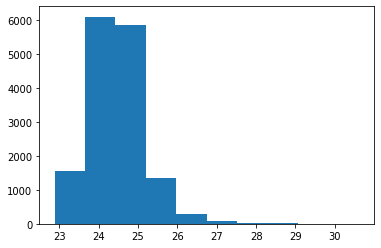

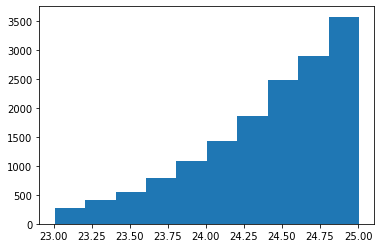

In [ ]:
plt.hist(X_test_mags)
plt.show()

plt.hist(Y_test_mags)
plt.show()

## Min-Max scaling - Per Object

In [ ]:
mins, maxs = [], []

for i in range(np.shape(X_train)[0]):

  ### The max of the image comes from the input
  min, max = np.min(X_train[i]), np.max(X_train[i])

  ### Setting min = 0 
  min = 0 

  Y_train[i] = (Y_train[i] - min)/(max - min)
  X_train[i] = (X_train[i] - min)/(max - min)

  mins.append(min) 
  maxs.append(max)

cat_train['MIN_IMAGE'] = mins
cat_train['MAX_IMAGE'] = maxs


mins, maxs = [], []

for i in range(np.shape(X_test)[0]):

  ### The max of the image comes from the input
  min, max = np.min(X_test[i]), np.max(X_test[i])

  ### Setting min = 0 
  min = 0 

  Y_test[i] = (Y_test[i] - min)/(max - min)
  X_test[i] = (X_test[i] - min)/(max - min)

  mins.append(min) 
  maxs.append(max)

cat_test['MIN_IMAGE'] = mins
cat_test['MAX_IMAGE'] = maxs

## Train/Test Distributions!


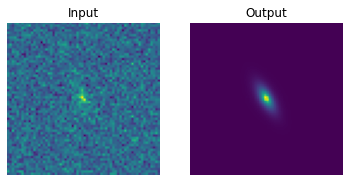

In [ ]:
n = np.random.randint(0, np.shape(X_train)[0])

plt.subplot(1, 2, 1) 
plt.imshow(X_train[n])
plt.title('Input')
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(Y_train[n])
plt.title('Output')
plt.axis('off')

plt.show()

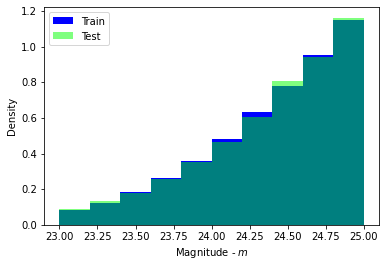

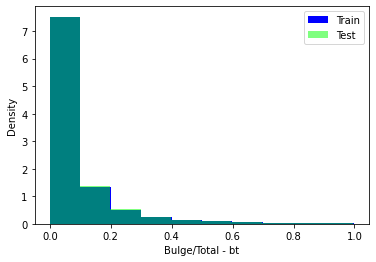

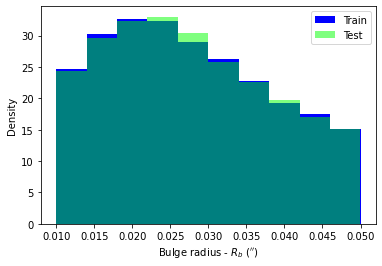

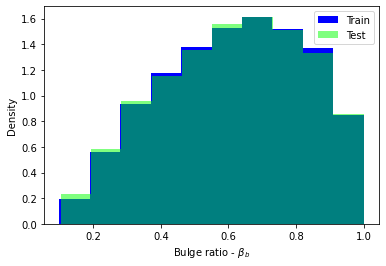

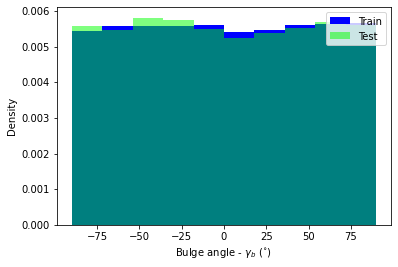

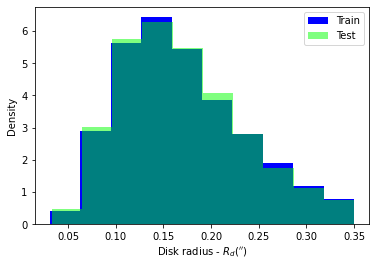

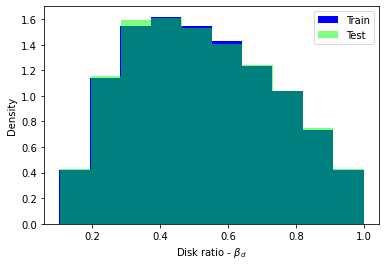

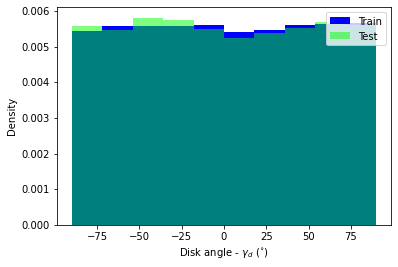

In [ ]:
properties_to_inspect = ['mag', 'bt', 'bulge_radius', 'bulge_ratio', 'bulge_angle', 'disk_radius', 'disk_ratio', 'disk_angle']
properties_to_inspect_labels = ['Magnitude - $m$', 'Bulge/Total - bt', 'Bulge radius - $R_b$ ($^{\prime\prime}$)', r'Bulge ratio - $\beta_b$', 'Bulge angle - $\gamma_b$ ($^{\circ}$)', 'Disk radius - $R_d$($^{\prime\prime}$)', r'Disk ratio - $\beta_d$', 'Disk angle - $\gamma_d$ ($^{\circ}$)']

for i, p in enumerate(properties_to_inspect): 
  plt.hist(cat_train[p], density=True, label='Train',  ls='dashed', lw=1, fc=(0, 0, 1, 1))
  plt.hist(cat_test[p], density=True, label='Test',  ls='dashed', lw=1, fc=(0, 1, 0, 0.5))
  plt.xlabel(properties_to_inspect_labels[i])
  plt.ylabel('Density')
  plt.legend()
  plt.show()

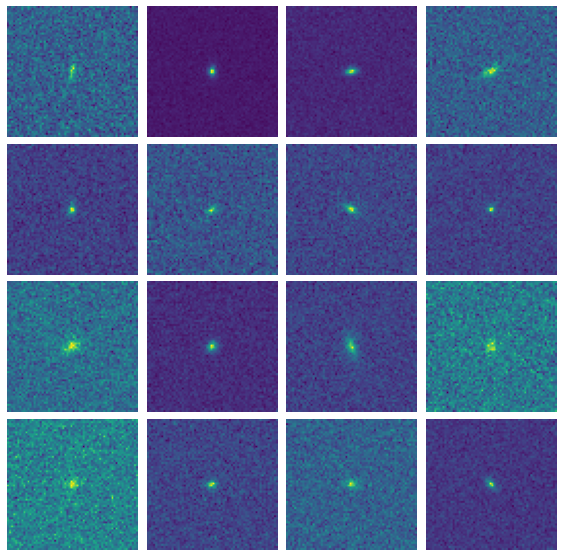

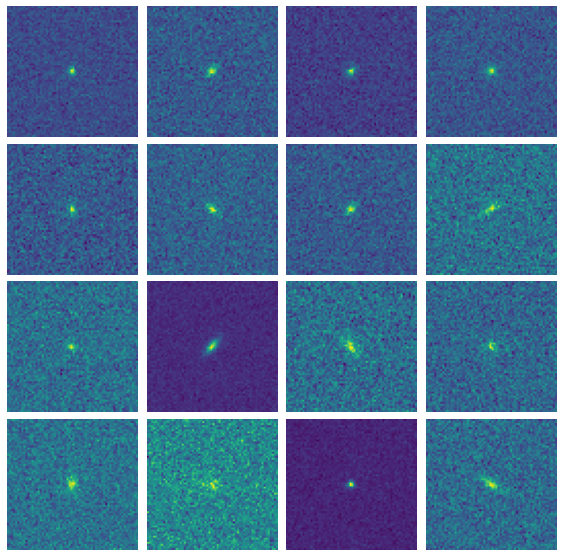

In [ ]:
random_indices_train = np.random.randint(0, np.shape(X_train)[0], 16)

fig = plt.figure(figsize=(10,10))

for i, idx in enumerate(random_indices_train):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[idx])
    plt.axis('off')

fig.subplots_adjust(wspace=0, hspace=0.05)
# plt.suptitle('Train set examples', y=0.9, fontsize=15)
plt.show()

print("")

random_indices_test = np.random.randint(0, np.shape(X_test)[0], 16)

fig = plt.figure(figsize=(10,10))

for i, idx in enumerate(random_indices_test):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_test[idx])
    plt.axis('off')

fig.subplots_adjust(wspace=0, hspace=0.05)
# plt.suptitle('Test set examples', y=0.9, fontsize=15)
plt.show()

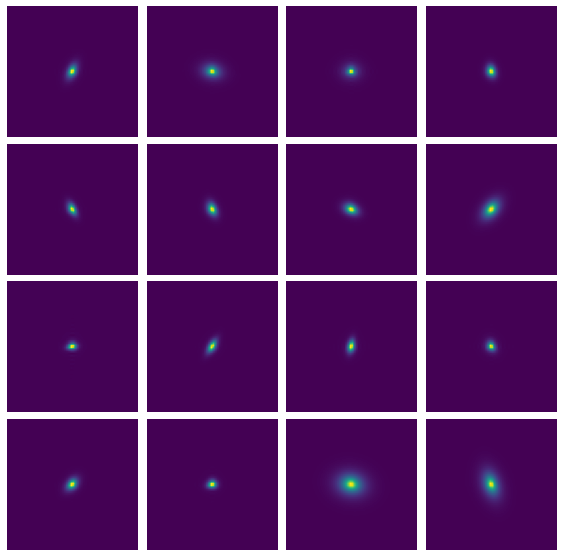

In [ ]:
random_indices_test = np.random.randint(0, np.shape(Y_test)[0], 16)

fig = plt.figure(figsize=(10,10))

for i, idx in enumerate(random_indices_test):
    plt.subplot(4, 4, i+1)
    plt.imshow(Y_test[idx])
    plt.axis('off')

fig.subplots_adjust(wspace=0, hspace=0.05)
# plt.suptitle('Test set examples', y=0.9, fontsize=15)
plt.show()

# Expanding dimensions

In [ ]:
X_train = np.expand_dims(X_train, axis=-1) # expand dims for the channel 
X_test = np.expand_dims(X_test, axis=-1)

Y_train = np.expand_dims(Y_train, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

In [ ]:
np.shape(X_train), np.shape(X_test)

((61533, 64, 64, 1), (15384, 64, 64, 1))

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, MaxPool2D, Input, Lambda, add, GaussianNoise, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model

import datetime, os
from datetime import datetime

In [ ]:
def sampling(args):
    
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    
    return mean_mu + K.exp(log_var/2)*epsilon 

# Model


In [ ]:
##5x filters 

def build_vae_encoder(input_dim, output_dim):
        
    encoder_input = Input(shape=input_dim, name='Input')

    x = Conv2D(filters=16, kernel_size=3, strides=(2,2), 
               activation='relu', input_shape=input_dim, 
               padding='same', kernel_regularizer=regularizers.L2(l2=1e-5), name='1st-Conv2D')(encoder_input)
    x = Conv2D(filters=32, kernel_size=3, strides=(2,2), 
               activation='relu',  padding='same', kernel_regularizer=regularizers.L2(l2=1e-5), name='2nd-Conv2D')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=(2,2), 
               activation='relu', padding='same', kernel_regularizer=regularizers.L2(l2=1e-5), name='3rd-Conv2D')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=(2,2), 
               activation='relu', padding='same', name='4th-Conv2D')(x)
    x = Flatten(name='Reshape')(x)
    x = Dense(output_dim, input_shape=[4096], 
              activation='relu', name='1st-Dense')(x)
    mu = Dense(output_dim, name=r'Mean')(x)
    log_sigma = Dense(output_dim, name=r'Sigma')(x)
    
    encoder_output = Lambda(function=sampling, name='Sample')([mu, log_sigma])
    
    return encoder_input, encoder_output, mu, log_sigma, Model(encoder_input, 
                                                               encoder_output)

def build_vae_decoder(input_dim):
            
    decoder_input = Input(shape=input_dim, name='Input')
    y = Dense(4096, activation='relu', name='1st-Dense')(decoder_input)
    y = Reshape((4, 4, 256), name='Reshape')(y)
    y = Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), 
                        padding='same',activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5), name='1st-Conv2DT')(y)
    y = Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2), 
                        padding='same', activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5), name='2nd-Conv2DT')(y)
    y = Conv2DTranspose(filters=16, kernel_size=3, strides=(2,2), 
                        padding='same', activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5), name='3rd-Conv2DT')(y)
    decoder_output = Conv2DTranspose(filters=1, kernel_size=3, 
                    strides=(2,2), padding='same', activation='sigmoid', name='4th-Conv2DT')(y)
    
    return decoder_input, decoder_output, Model(decoder_input, 
                                                decoder_output)

In [ ]:
vae_encoder_input, vae_encoder_output, mu, log_var, vae_encoder = build_vae_encoder((64,64,1), 100)
vae_decoder_input, vae_decoder_output, vae_decoder = build_vae_decoder(100)

In [ ]:
# vae_encoder.summary()

In [ ]:
# vae_decoder.summary()

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)
vae_model = Model(vae_input, vae_output)

In [ ]:
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 1st-Conv2D (Conv2D)            (None, 32, 32, 16)   160         ['Input[0][0]']                  
                                                                                                  
 2nd-Conv2D (Conv2D)            (None, 16, 16, 32)   4640        ['1st-Conv2D[0][0]']             
                                                                                                  
 3rd-Conv2D (Conv2D)            (None, 8, 8, 64)     18496       ['2nd-Conv2D[0][0]']             
                                                                                            

In [ ]:
model_name = 'VAE_I_Poisson_64x64'

In [ ]:
# plot_model(vae_encoder, to_file='model_vae_encoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
# plot_model(vae_decoder, to_file='model_vae_decoder.png', show_shapes=True, show_layer_names=True)

### Training for the first time 

In [ ]:
# # def scheduler(epoch, lr):

# #   if epoch < 10:
# #     return lr
# #   else:
# #     return lr * tf.math.exp(-0.1)

# def scheduler(epoch, lr):
#   if epoch < 50:
#     return lr
#   else:
#     if epoch%50 == 0:
#       return lr * 0.95
#     else:
#       return lr 

# steplr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# lr = 0.0005
# batch_size = 32

# loss_factor = 1
# loss_factor_kl = 5e-9

# # reconstruction loss MSE
# def r_loss(y_true, y_pred):
#     return K.mean( K.square(y_true - y_pred), axis = [1,2])

# # KL - divergence loss 
# def kl_loss(y_true, y_pred):
#     kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
#     return kl_loss

# def total_loss(y_true, y_pred):
#     return loss_factor * r_loss(y_true, y_pred) + loss_factor_kl*kl_loss(y_true, y_pred)

# vae_model.compile(optimizer=Adam(learning_rate = lr), loss = total_loss, metrics = [r_loss, kl_loss])

# early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# ## With X, Y train where these are numpy arrays 
# vae_model.fit(X_train, Y_train, epochs = 1000, validation_data=(X_test, Y_test), callbacks=[early_stop], batch_size=batch_size)

In [ ]:
# losses = pd.DataFrame(vae_model.history.history)
# losses.columns

In [ ]:
# losses[['loss','val_loss']].plot()
# plt.yscale('log')
# plt.ylabel('Total loss; recon + kl_div')
# plt.xlabel('Epochs')

## Saving model

In [ ]:
# vae_decoder.save_weights('checkpoints/checkpoint-decoder-'+model_name+'/')

In [ ]:
# vae_model.save_weights('checkpoints/checkpoint-model-'+model_name+'/')

## Loading a previously saved model

In [ ]:
lr = 0.0005
batch_size = 32

loss_factor = 1
loss_factor_kl = 5e-9

# reconstruction loss MSE
def r_loss(y_true, y_pred):
    return K.mean( K.square(y_true - y_pred), axis = [1,2])

# KL - divergence loss 
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return loss_factor * r_loss(y_true, y_pred) + loss_factor_kl*kl_loss(y_true, y_pred)


In [ ]:
vae_model.load_weights('checkpoints/checkpoint-model-'+model_name+'/')

In [ ]:
vae_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = lr), loss = total_loss, metrics = [r_loss, kl_loss])
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 1st-Conv2D (Conv2D)            (None, 32, 32, 16)   160         ['Input[0][0]']                  
                                                                                                  
 2nd-Conv2D (Conv2D)            (None, 16, 16, 32)   4640        ['1st-Conv2D[0][0]']             
                                                                                                  
 3rd-Conv2D (Conv2D)            (None, 8, 8, 64)     18496       ['2nd-Conv2D[0][0]']             
                                                                                            

## Evaluating model


In [ ]:
vae_model.evaluate(X_test, Y_test), vae_model.metrics_names

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


([3.154008631112957e-05, 2.4457328e-05, 296.845],
 ['loss', 'r_loss', 'kl_loss'])

## Contracting dimensions

In [ ]:
Y_test_predict = vae_model.predict(X_test)
Y_test_predict = Y_test_predict.reshape((-1, 64, 64))

X_train = X_train.reshape((-1, 64, 64))
X_test = X_test.reshape((-1, 64, 64))

Y_train = Y_train.reshape((-1, 64, 64))
Y_test = Y_test.reshape((-1, 64, 64))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Min-Max scaling inverse - Per Object

In [ ]:
for i in range(np.shape(X_train)[0]): 
  min, max = cat_train['MIN_IMAGE'].values[i], cat_train['MAX_IMAGE'].values[i]

  X_train[i] =  X_train[i] * (max - min) + min 
  Y_train[i] =  Y_train[i] * (max - min) + min 

for i in range(np.shape(X_test)[0]): 
  min, max = cat_test['MIN_IMAGE'].values[i], cat_test['MAX_IMAGE'].values[i]

  X_test[i] =  X_test[i] * (max - min) + min 
  Y_test[i] =  Y_test[i] * (max - min) + min 
  Y_test_predict[i] =  Y_test_predict[i] * (max - min) + min 

# Light Profile examples

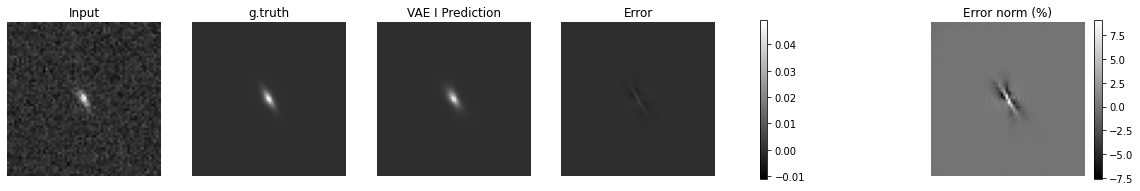

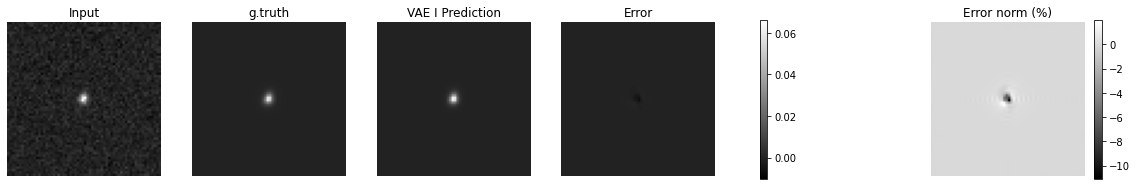

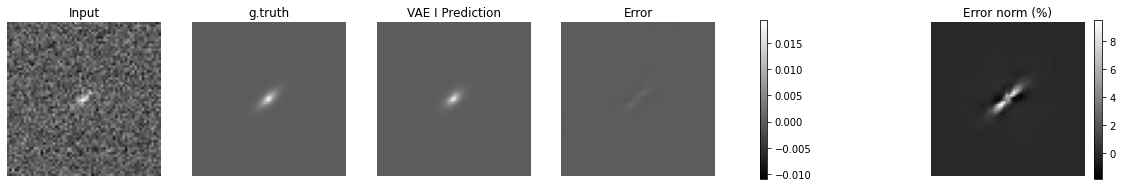

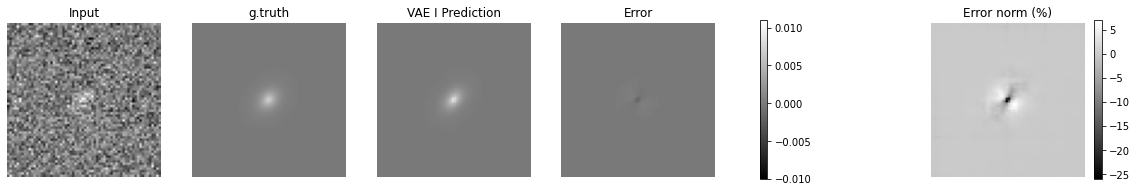

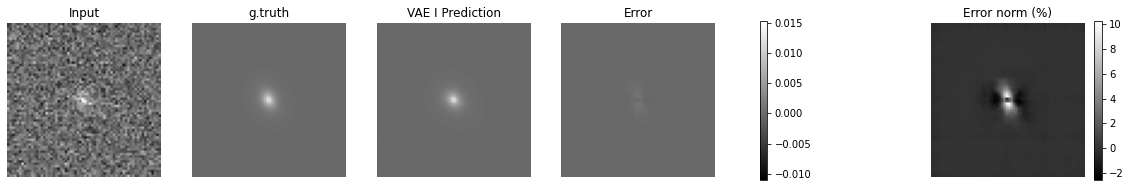

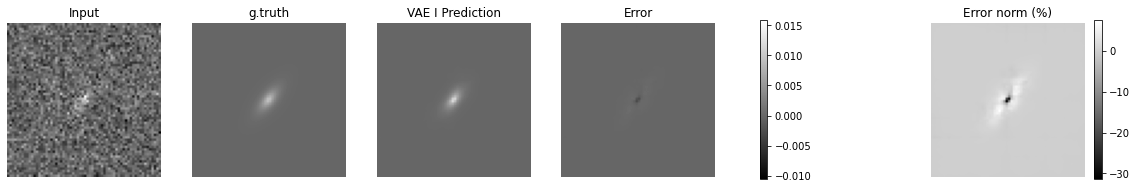

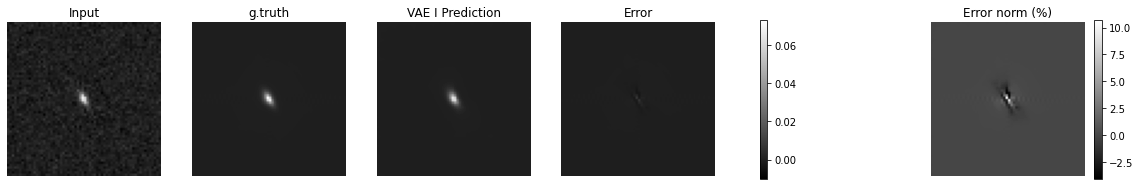

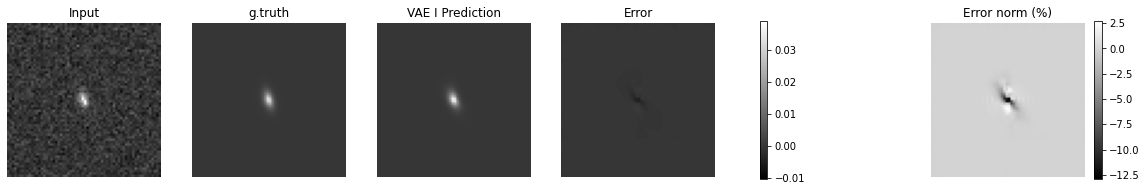

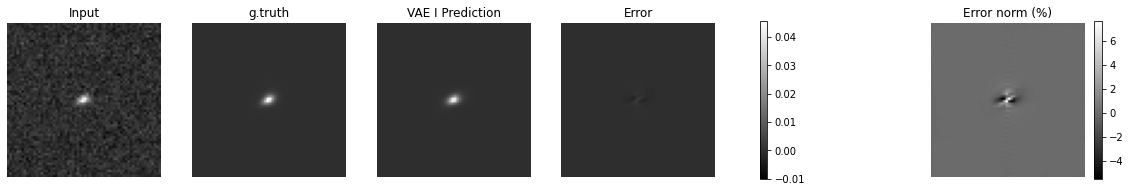

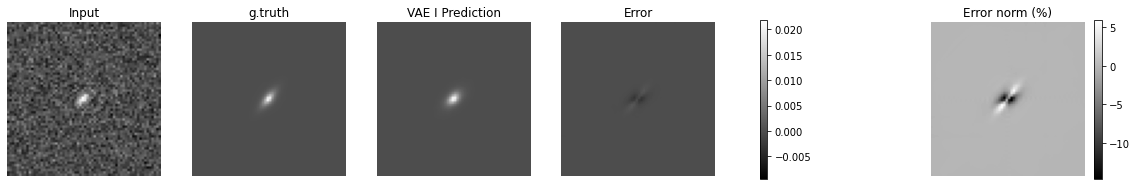

In [ ]:
for i in range(10, 20):

  n = np.random.randint(0, np.shape(Y_test)[0])

  fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

  im1 = ax0.imshow(X_test[n], cmap='gray')
  ax0.set_title('Input')
  ax0.axis('off')

  im2 = ax1.imshow(Y_test[n], cmap='gray')
  ax1.set_title('g.truth')
  ax1.axis('off')

  im3 = ax2.imshow(Y_test_predict[n], cmap='gray')
  ax2.set_title('VAE I Prediction')
  ax2.axis('off')

  im4 = ax3.imshow(Y_test[n]-Y_test_predict[n], cmap='gray')
  ax3.set_title('Error')
  ax3.axis('off')

  im5 = ax4.imshow(100 * (Y_test[n]-Y_test_predict[n])/ np.max(Y_test[n]), cmap='gray')
  ax4.set_title('Error norm (%)')
  ax4.axis('off')

  images = [im1, im2, im3, im4]
  vmin = np.min([image.get_array().min() for image in images])
  vmax = np.max([image.get_array().max() for image in images])
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
      im.set_norm(norm)

  fig.colorbar(images[0], ax=[ax0, ax1, ax2, ax3], shrink=0.73)
  fig.colorbar(im5, ax=[ax4], shrink=0.73)
  # fig.suptitle("Magnitude of central galaxy %.2f and half light radius %.2f" %(cat_test[n, 4], cat_test[n, 6]*0.03))

  plt.show()

# Reconstruction metrics


### MSE, CrossEntropy, CosineDistance


In [ ]:
def fnmse(yHat, y):
    return np.mean((yHat-y)**2)

def bCrossEntropy(yHat, y):
    return -np.mean(y*np.log(yHat) + (1-y)*np.log(1-yHat))

def cosinedist(yHat, y):
    
    u = yHat.flatten()
    v = y.flatten() 
    normu = np.sqrt(np.sum(u**2))
    normv = np.sqrt(np.sum(v**2)) 
    cosine_dist = np.dot(u, v) / (normu*normv)
    
    return 1 - cosine_dist

In [ ]:
n_test = np.shape(Y_test)[0]
mse, cd = np.zeros(n_test), np.zeros(n_test)
mu, std = np.zeros(n_test), np.zeros(n_test)

for i in range(n_test):
    
    yHat, y = Y_test_predict[i], Y_test[i]
    
    mse[i] += fnmse(yHat, y)
    cd[i] += cosinedist(yHat, y)
    mu[i] += np.mean(yHat - y)
    std[i] += np.std(yHat - y)

print("Mean square error", np.sum(mse)/n_test)
print("Cosine distance", np.sum(cd)/n_test)

Mean square error 2.651958430405129e-08
Cosine distance 0.005728021318318629


In [ ]:
def ret_running_mean(x, y, n=20): 

  a, b = np.min(x), np.max(x)
  interval = (b-a)/n 

  x_, y_ = np.zeros(n), np.zeros(n)
  
  for i in range(n):

    mask1 = a+interval*i < x
    mask2 = a+interval*(i+1) > x

    x_[i] = np.mean(x[mask1 & mask2])
    y_[i] = np.mean(y[mask1 & mask2])

  return x_, y_

def ret_running_std(x, y, n=20): 

  a, b = np.min(x), np.max(x)
  interval = (b-a)/n 

  x_, y_ = np.zeros(n), np.zeros(n)
  
  for i in range(n):

    mask1 = a+interval*i < x
    mask2 = a+interval*(i+1) > x

    x_[i] = np.mean(x[mask1 & mask2])
    y_[i] = np.std(y[mask1 & mask2])

  return x_, y_

def ret_running_median(x, y, n=20): 

  a, b = np.min(x), np.max(x)
  interval = (b-a)/n 

  x_, y_ = np.zeros(n), np.zeros(n)
  
  for i in range(n):

    mask1 = a+interval*i < x
    mask2 = a+interval*(i+1) > x

    x_[i] = np.median(x[mask1 & mask2])
    y_[i] = np.median(y[mask1 & mask2])

  return x_, y_

In [ ]:
Y_test_predict_flux = np.sum(np.sum(Y_test_predict, axis=1), axis=1)
Y_test_flux = np.sum(np.sum(Y_test, axis=1), axis=1)
Y_test_mag = FluxToMag(zp, Y_test_flux)

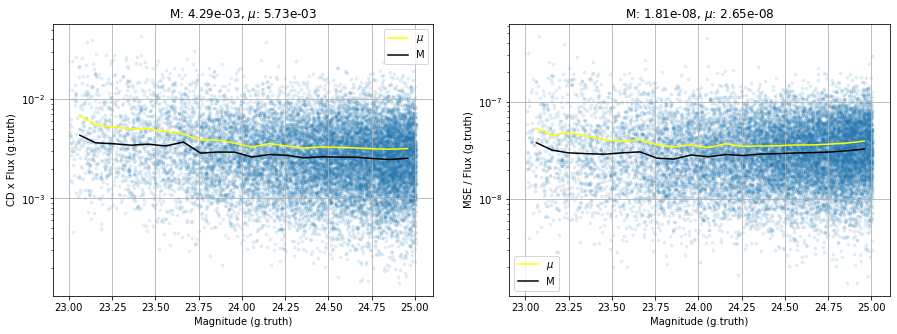

In [ ]:
f = plt.figure(figsize=(15, 5))

f.add_subplot(1, 2, 1)

plt.scatter(Y_test_mag, cd*Y_test_flux, alpha=0.1, s=7.0)

x_, cd_mean = ret_running_mean(Y_test_mag, cd*Y_test_flux)
plt.plot(x_, cd_mean, c='yellow', label=f'$\mu$')

x_, cd_median = ret_running_median(Y_test_mag, cd*Y_test_flux)
plt.plot(x_, cd_median, c='black', label=f'M')

plt.xlabel('Magnitude (g.truth)')
plt.ylabel('CD x Flux (g.truth)')
plt.title(f'M: {"{:.2e}".format(np.median(cd))}, $\mu$: {"{:.2e}".format(np.sum(cd) / len(cd))}')
plt.yscale('log')
plt.grid()
plt.legend()

f.add_subplot(1, 2, 2)

plt.scatter(Y_test_mag, mse/Y_test_flux, alpha=0.1, s=7.0)
# plot running mean & median

x_, mse_mean = ret_running_mean(Y_test_mag, mse/Y_test_flux)
plt.plot(x_, mse_mean, c='yellow', label=f'$\mu$')

x_, mse_median = ret_running_median(Y_test_mag, mse/Y_test_flux)
plt.plot(x_, mse_median, c='black', label=f'M')

plt.xlabel('Magnitude (g.truth)')
plt.ylabel('MSE / Flux (g.truth)')
plt.title(f'M: {"{:.2e}".format(np.median(mse))}, $\mu$: {"{:.2e}".format(np.sum(mse) / len(mse))}')
plt.yscale('log')
plt.grid()
plt.legend()

plt.show(block=True)

### Flux error 


In [ ]:
mean_image = np.mean(Y_test, axis=0)
median_image = np.median(Y_test, axis=0)

In [ ]:
print(f'The flux of mean image is {np.sum(mean_image)} and mag is {FluxToMag(zp, np.sum(mean_image))}')
print(f'The flux of median image is {np.sum(median_image)} and mag is {FluxToMag(zp, np.sum(median_image))}')

The flux of mean image is 0.6999397277832031 and mag is 24.287348383665083
The flux of median image is 0.5381554961204529 and mag is 24.572730579972266


In [ ]:
error = (Y_test_predict_flux - Y_test_flux)/Y_test_flux

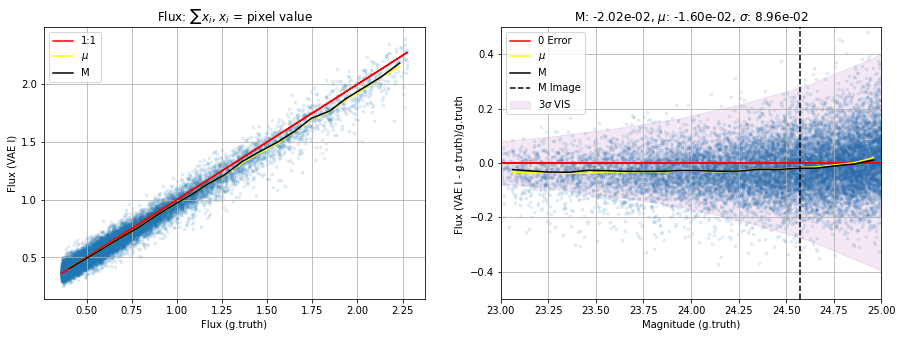

In [ ]:
f = plt.figure(figsize=(15, 5))

f.add_subplot(1, 2, 1)

plt.scatter(Y_test_flux, Y_test_predict_flux,  alpha=0.1, s=7.0)
plt.plot(Y_test_flux, Y_test_flux, c='r', label='1:1')

# plot running mean & median

x_, y_ = ret_running_mean(Y_test_flux, Y_test_predict_flux)
plt.plot(x_, y_, c='yellow', label=f'$\mu$')

x_, y_ = ret_running_median(Y_test_flux, Y_test_predict_flux)
plt.plot(x_, y_, c='black', label=f'M')

plt.xlabel('Flux (g.truth)')
plt.ylabel('Flux (VAE I)')
plt.title(f'Flux: $\sum x_i$, $x_i$ = pixel value')
plt.legend()
plt.grid()

f.add_subplot(1, 2, 2)

med = np.median(error)
avg = np.mean(error)
std = np.std(error)

plt.scatter(Y_test_mag, error, alpha=0.1, s=7.0)
plt.plot(Y_test_mag, np.zeros(np.shape(Y_test_mag)[0]), c='r', label='0 Error')

# plot running mean & median

x_, y_ = ret_running_mean(Y_test_mag, error)
plt.plot(x_, y_, c='yellow', label=f'$\mu$')

x_, y_ = ret_running_median(Y_test_mag, error)
plt.plot(x_, y_, c='black', label=f'M')
# plt.errorbar(expected_mags, np.zeros(np.shape(expected_mags)[0]), yerr=expected_stds, color='r')

plt.fill_between(expected_mags, 0+3*np.array(expected_stds),0-3*np.array(expected_stds),color='purple',alpha=.09, label=f'3$\sigma$ VIS')
              
# plt.axvline(FluxToMag(zp, np.sum(mean_image)), c='black', linestyle='--', label='$\mu$ Image')
plt.axvline(FluxToMag(zp, np.sum(median_image)), c='black', linestyle='--', label='M Image')

plt.ylim(-0.5, 0.5)
plt.xlim(23, 25)

plt.xlabel('Magnitude (g.truth)')
plt.ylabel('Flux (VAE I - g.truth)/g.truth ')
plt.title(f'M: {"{:.2e}".format(med)}, $\mu$: {"{:.2e}".format(avg)}, $\sigma$: {"{:.2e}".format(std)}')
plt.legend()
plt.grid()

plt.show(block=True)

In [ ]:
expected_mags_start, expected_mags_end = expected_mags[:-1], expected_mags[1:]
expected_stds_start, expected_stds_end = expected_stds[:-1], expected_stds[1:]


inside = []
outside = []

for i in range(np.shape(expected_mags_start)[0]):

  mask_mag = (Y_test_mag > expected_mags_start[i]) & (Y_test_mag < expected_mags_end[i])

  Y_test_mag_mask = Y_test_mag[mask_mag]
  error_mag_mask = error[mask_mag]

  mask_error_3sig = np.absolute(error_mag_mask) < 3*(np.mean([expected_stds_start[i], expected_stds_end[i]]))

  inside.append(np.shape(error_mag_mask[mask_error_3sig])[0])
  outside.append(np.shape(error_mag_mask[~mask_error_3sig])[0])


In [ ]:
sum(inside)/(sum(outside)+sum(inside)) 

0.9748439937597504

# T-SNE Visulization of latent space

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
from tensorflow.keras import backend as K

layerIndex = 9
func = K.function([vae_model.get_layer(index=0).input], vae_model.get_layer(index=layerIndex).output)
layerOutput = func(np.expand_dims(X_test, axis=-1))  # input_data is a numpy array

print(layerOutput.shape)

(15384, 100)


In [ ]:
ls = TSNE(n_components=2).fit_transform(layerOutput)
ls.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(15384, 2)

Text(0, 0.5, 'Dim 2')

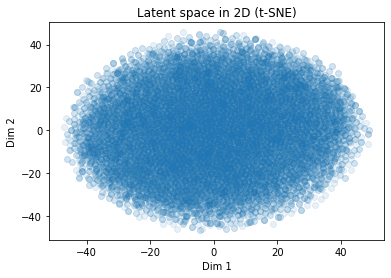

In [ ]:
plt.scatter(ls[:,0],ls[:,1], alpha=0.1)
plt.title(f'Latent space in 2D (t-SNE)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

# SExtractor results

In [ ]:
# read catalog 
catalog_name = data_directory+'SExtractor_results/Isolated/sext_catalog_i_X_test.csv'
cat_sext_test = pd.read_csv(catalog_name)

In [ ]:
sext_X_test_img_file = data_directory+'SExtractor_results/Isolated/sext_i_X_test_img.npy'
sext_X_test_img = np.load(sext_X_test_img_file)

sext_X_test_seg_file = data_directory+'SExtractor_results/Isolated/sext_i_X_test_seg.npy'
sext_X_test_seg = np.load(sext_X_test_seg_file)

sext_X_test_apr_file = data_directory+'SExtractor_results/Isolated/sext_i_X_test_apr.npy'
sext_X_test_apr = np.load(sext_X_test_apr_file)

In [ ]:
Y_sext_flux = cat_sext_test['FLUX_AUTO'].values
# Y_sext_flux = cat_sext_test['FLUX_AUTO'].values + cat_sext_test['BACKGROUND']*cat_sext_test['KRON_RADIUS']**2*cat_sext_test['A_IMAGE']*cat_sext_test['B_IMAGE'].values*np.pi
error_sext = (Y_sext_flux - Y_test_flux)/Y_test_flux

cat_sext_test['ERROR_VAE'] = error
cat_sext_test['TEST_VAE_MAG'] = Y_test_mag
cat_sext_test['ERROR_SEXT'] = error_sext
cat_sext_test['SEXT_BKG_CORRECT_FLUX'] = Y_sext_flux

In [ ]:
len(cat_sext_test), len(np.absolute(error) < np.absolute(error_sext))/len(cat_sext_test)

(15384, 1.0)

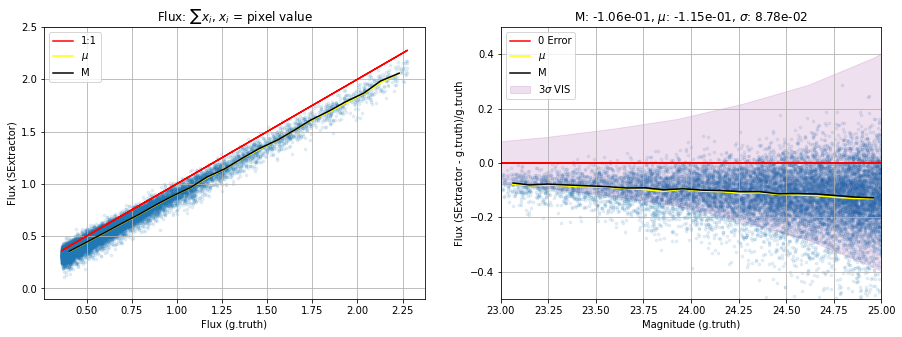

In [ ]:
mask = cat_sext_test['NO_OBJECTS'].values == 1

Y_test_flux_mask = Y_test_flux[mask]
Y_sext_flux_mask = Y_sext_flux[mask]
error_sext_mask = error_sext[mask]
Y_test_mag_mask = Y_test_mag[mask]

f = plt.figure(figsize=(15, 5))

f.add_subplot(1, 2, 1)

plt.scatter(Y_test_flux_mask, Y_sext_flux_mask, alpha=0.1, s=7.0)
plt.plot(Y_test_flux_mask, Y_test_flux_mask, c='r', label='1:1')
plt.xlabel('Flux (g.truth)')
plt.ylabel('Flux (SExtractor)')
plt.ylim(-0.1, 2.5)

# plot running mean & median

x_, y_ = ret_running_mean(Y_test_flux_mask, Y_sext_flux_mask)
plt.plot(x_, y_, c='yellow', label=f'$\mu$')

x_, y_ = ret_running_median(Y_test_flux_mask, Y_sext_flux_mask)
plt.plot(x_, y_, c='black', label=f'M')

plt.title(f'Flux: $\sum x_i$, $x_i$ = pixel value')

plt.legend()
plt.grid()

f.add_subplot(1, 2, 2)

med = np.median(error_sext_mask)
avg = np.mean(error_sext_mask)
std = np.std(error_sext_mask)

plt.scatter(Y_test_mag_mask, error_sext_mask, alpha=0.1, s=7.0)
plt.plot(Y_test_mag_mask, np.zeros(np.shape(Y_test_mag_mask)[0]), c='r', label='0 Error')
plt.fill_between(expected_mags, 0+3*np.array(expected_stds),0-3*np.array(expected_stds),color='purple',alpha=.12, label=f'3$\sigma$ VIS')

# plot running mean & median

x_, y_ = ret_running_mean(Y_test_mag_mask, error_sext_mask)
plt.plot(x_, y_, c='yellow', label=f'$\mu$')

x_, y_ = ret_running_median(Y_test_mag_mask, error_sext_mask)
plt.plot(x_, y_, c='black', label=f'M')

plt.xlabel('Magnitude (g.truth)')
plt.ylabel('Flux (SExtractor - g.truth)/g.truth')
plt.title(f'M: {"{:.2e}".format(med)}, $\mu$: {"{:.2e}".format(avg)}, $\sigma$: {"{:.2e}".format(std)}')
plt.legend()
plt.ylim(-0.5, 0.5)
plt.xlim(23, 25)
plt.grid()

plt.show(block=True)


##### Where SExtractor NO_OBJECTS == 1

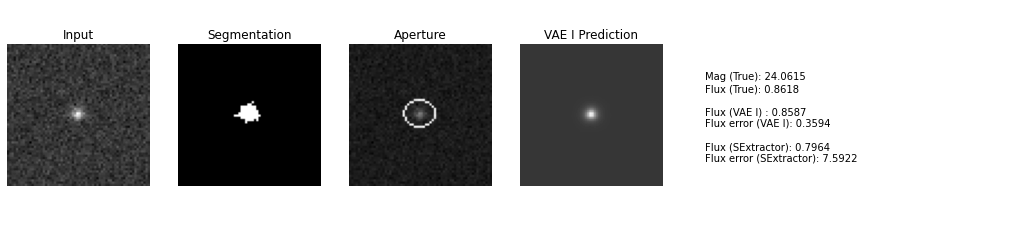

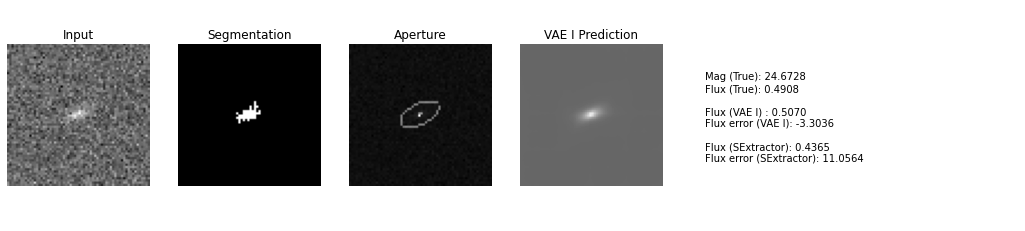

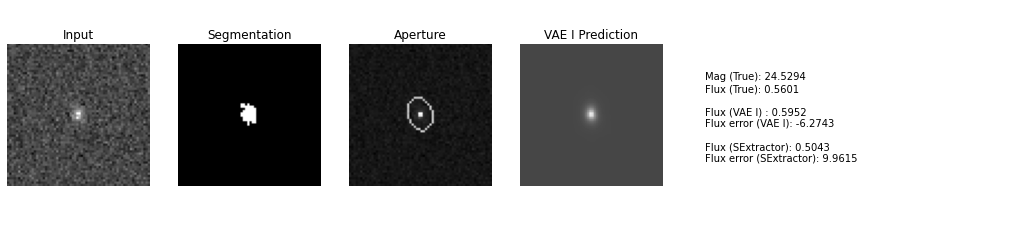

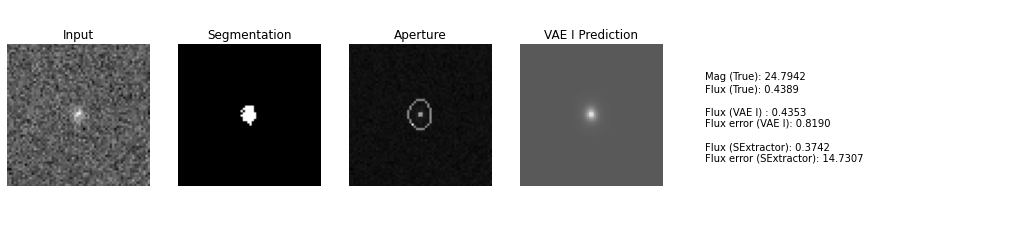

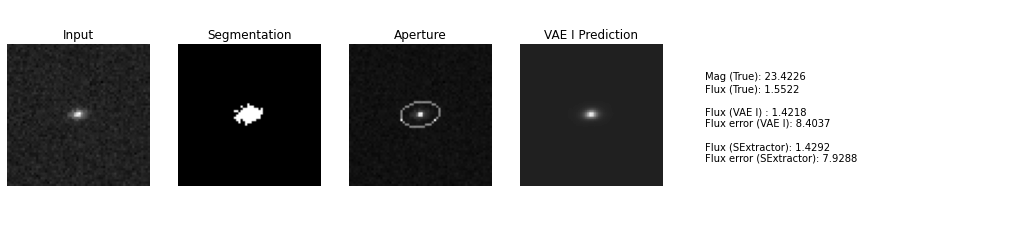

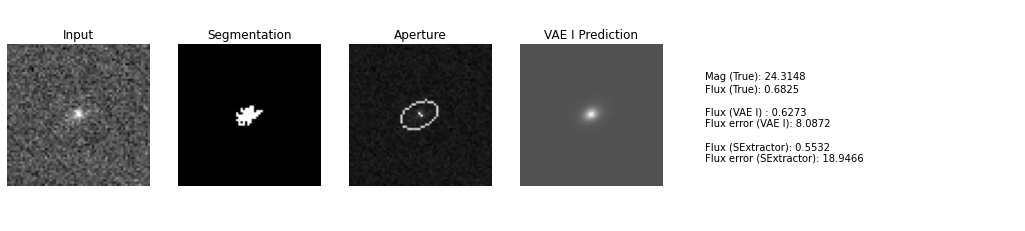

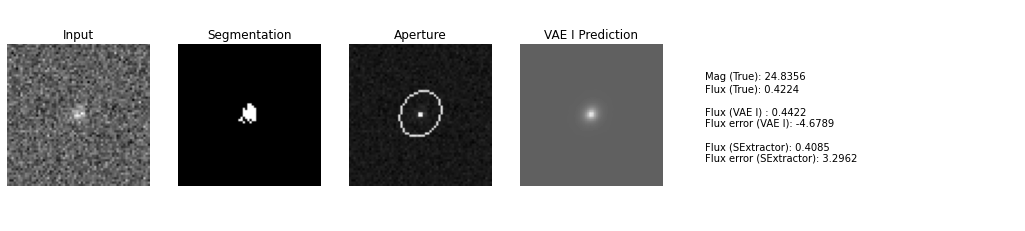

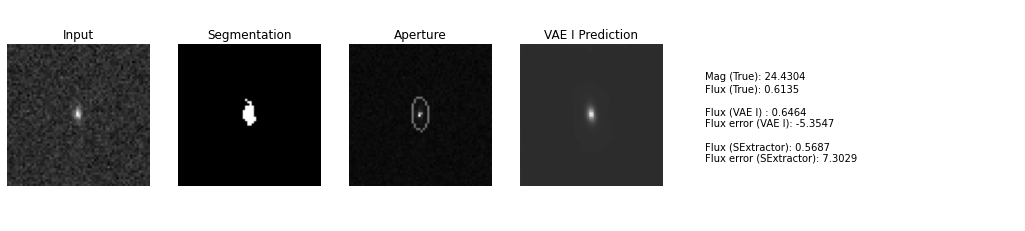

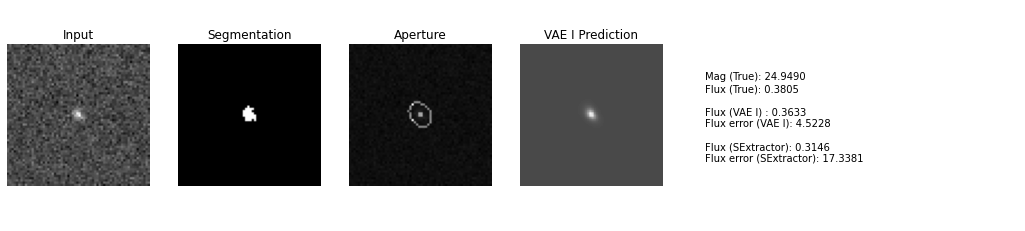

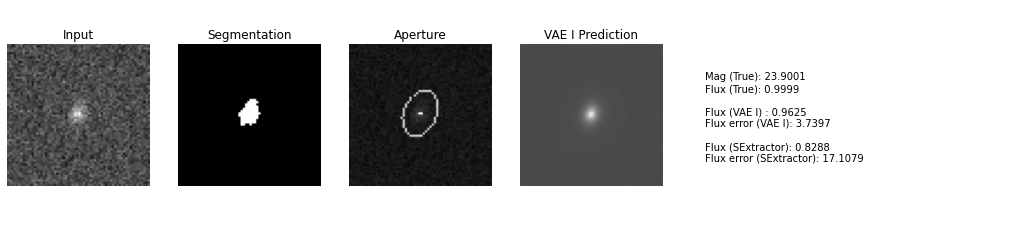

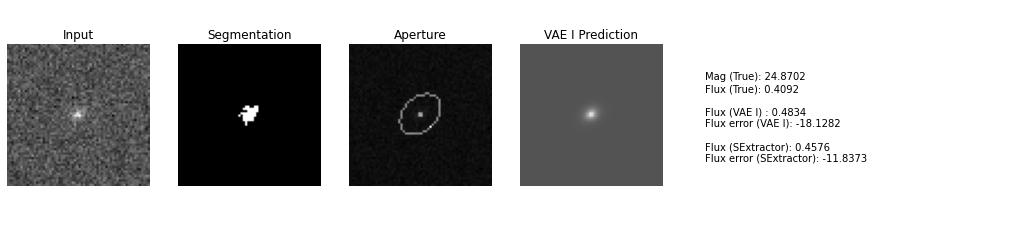

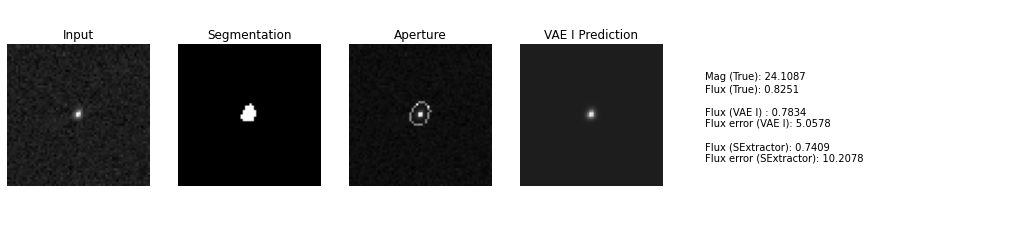

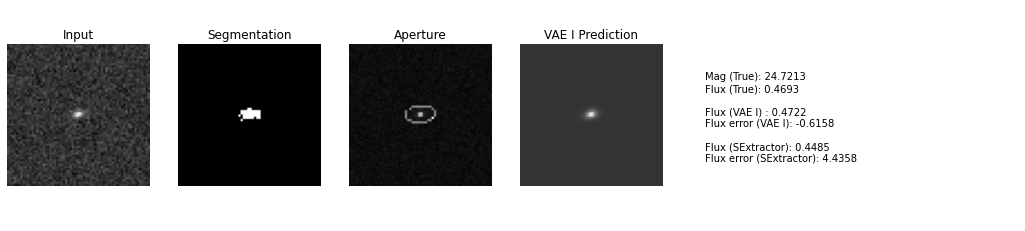

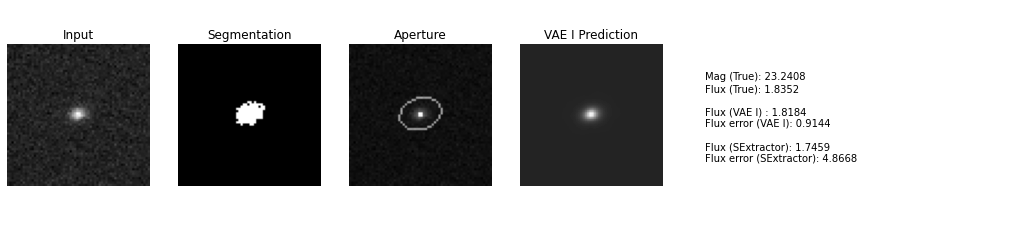

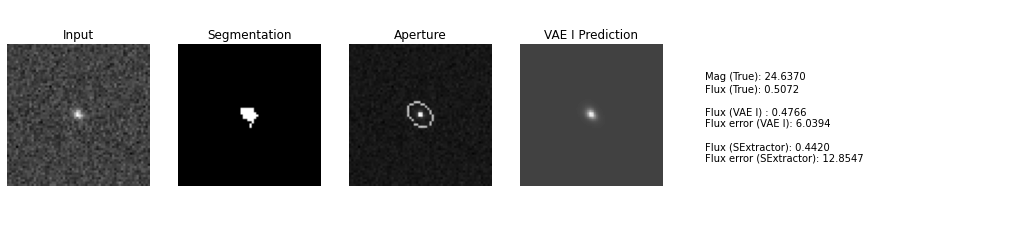

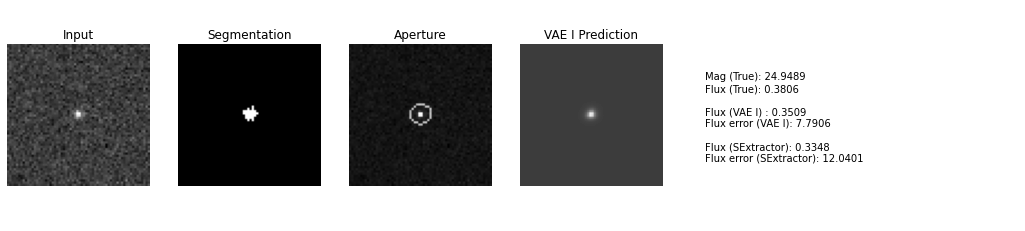

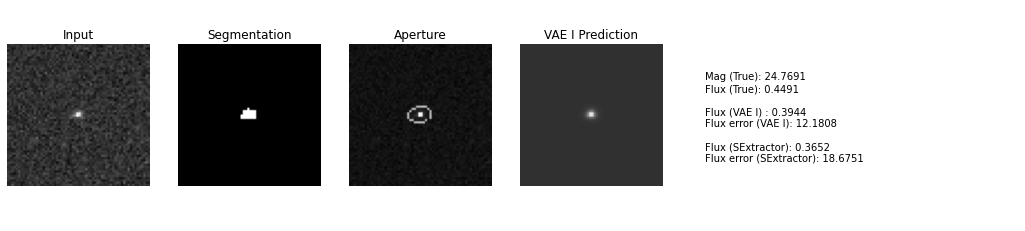

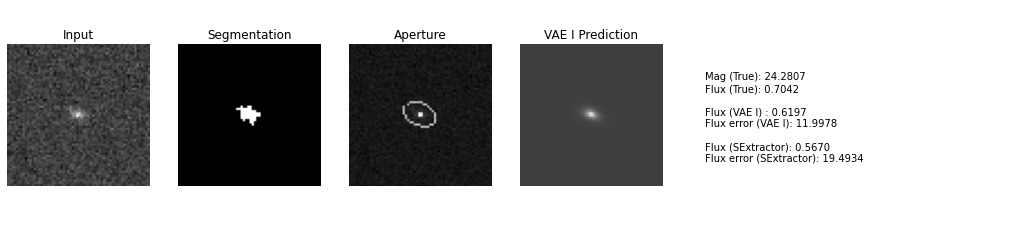

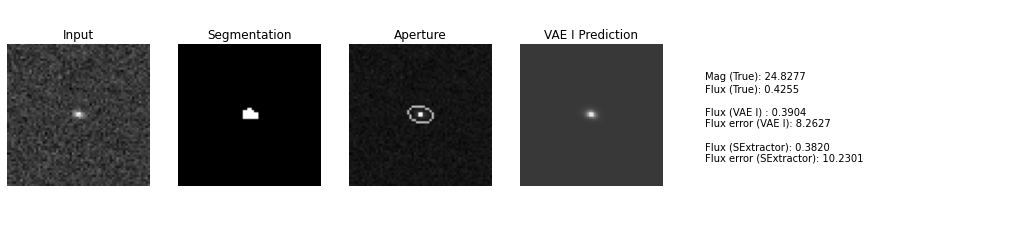

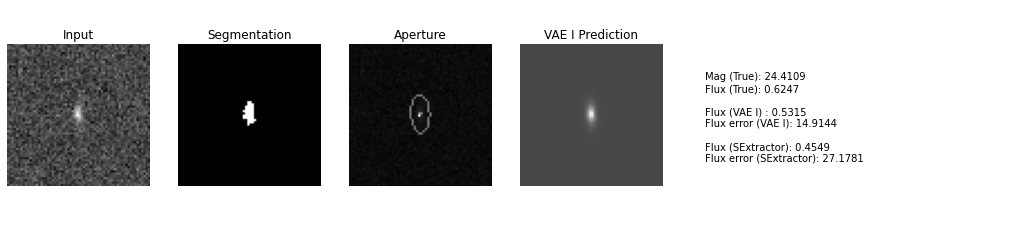

In [ ]:
for n in cat_sext_test[cat_sext_test['NO_OBJECTS'] == 1.0].index.tolist()[:20]: 

  ### SExtractor 

  fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(14.8, 4))

  im1 = ax0.imshow(sext_X_test_img[n], cmap='gray')
  ax0.set_title('Input')
  ax0.axis('off')

  im2 = ax1.imshow(sext_X_test_seg[n], cmap='gray')
  ax1.set_title('Segmentation')
  ax1.axis('off')

  im3 = ax2.imshow(sext_X_test_apr[n], cmap='gray')
  ax2.set_title('Aperture')
  ax2.axis('off')

  im4 = ax3.imshow(Y_test_predict[n], cmap='gray')
  ax3.set_title('VAE I Prediction')
  ax3.axis('off')

  images = [im1, im4]
  vmin = np.min([image.get_array().min() for image in images])
  vmax = np.max([image.get_array().max() for image in images])
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
      im.set_norm(norm)

  catalog_mag = cat_test.iloc[n, 4]
  catalog_flux = MagToFlux(zp, catalog_mag)

  vae_flux = np.sum(Y_test_predict[n])
  vae_mag = FluxToMag(zp, vae_flux)

  vae_error_flux = (catalog_flux-vae_flux)*100/catalog_flux
  vae_error_mag = (catalog_mag-vae_mag)*100

  sext_flux = cat_sext_test.loc[n, 'SEXT_BKG_CORRECT_FLUX']
  sext_error_flux = (catalog_flux-sext_flux)*100/catalog_flux

  if sext_flux == 0: 
    sext_mag = None
    sext_error_mag = None 
  else: 
    sext_mag = FluxToMag(zp, sext_flux)
    sext_error_mag = (catalog_mag-sext_mag)*100

  

  # info = f"Catalog mag: {catalog_mag}\nCatalog flux: {format(catalog_flux, '.4f')}\n\nVAE I flux: {format(vae_flux, '.4f')}\nVAE I flux error: {format(vae_error_flux, '.4f')}\n\nSExtractor flux: {format(sext_flux, '.4f')}\nSExtractor flux error: {format(sext_error_flux, '.4f')}"
  info = f"Mag (True): {format(catalog_mag, '.4f')}\nFlux (True): {format(catalog_flux, '.4f')}\n\nFlux (VAE I) : {format(vae_flux, '.4f')}\nFlux error (VAE I): {format(vae_error_flux, '.4f')}\n\nFlux (SExtractor): {format(sext_flux, '.4f')}\nFlux error (SExtractor): {format(sext_error_flux, '.4f')}"

  left, width = 0, 3.5
  bottom, height = 0.18, 0.66
  right = left + width
  top = bottom + height
  p = plt.Rectangle((left, bottom), width, height, fill=False, linewidth=0)
  p.set_transform(ax3.transAxes)
  p.set_clip_on(False)
  ax4.add_patch(p)
  ax4.axis('off')

  ax4.text(left+0.1, top-0.35, info,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax4.transAxes)

  ax4.axis('off')

  plt.show()


##### Where SExtractor NO_OBJECTS > 1

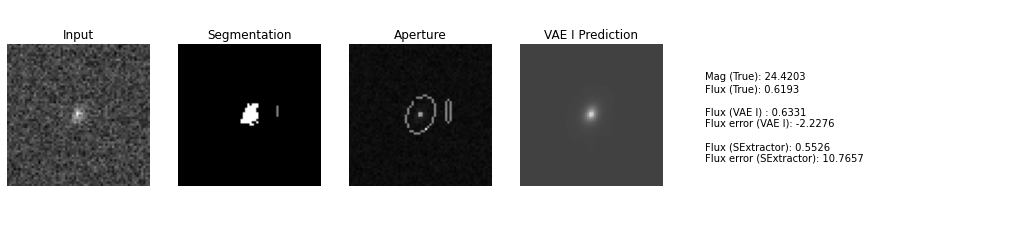

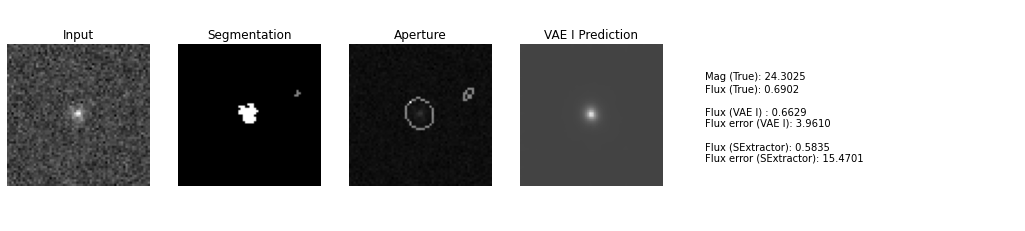

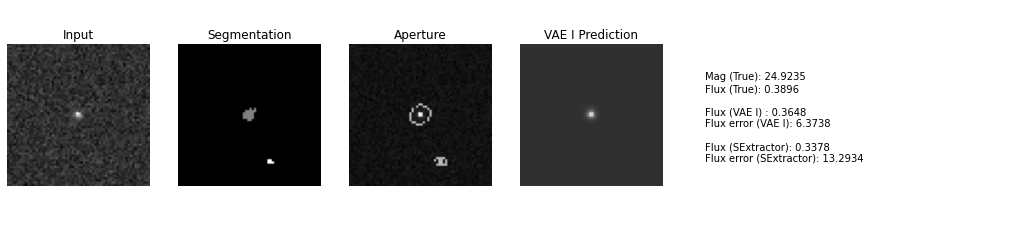

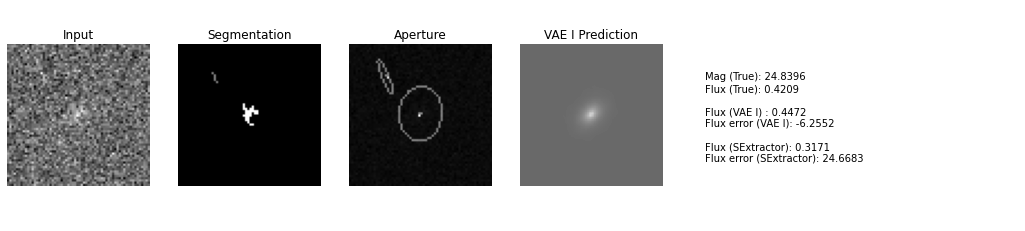

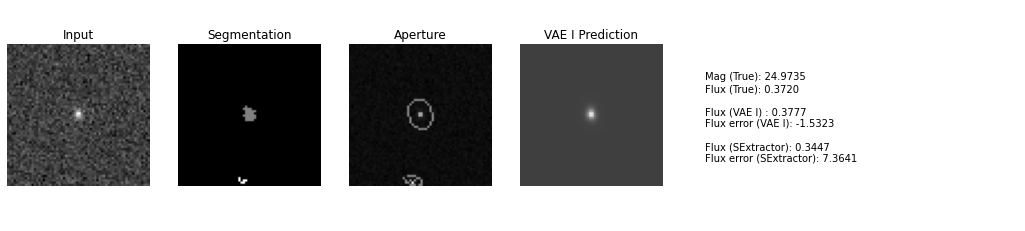

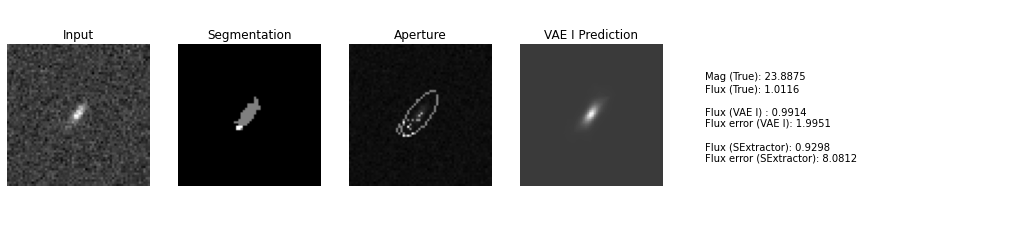

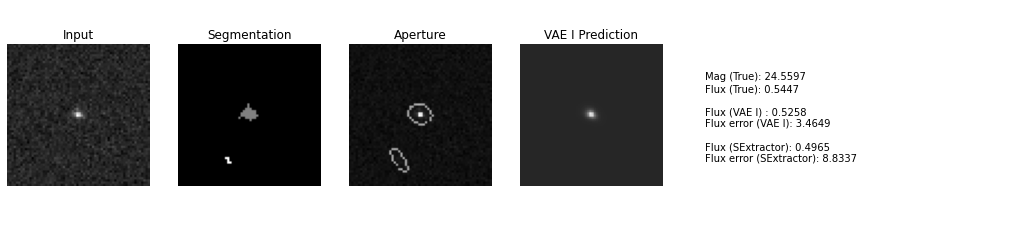

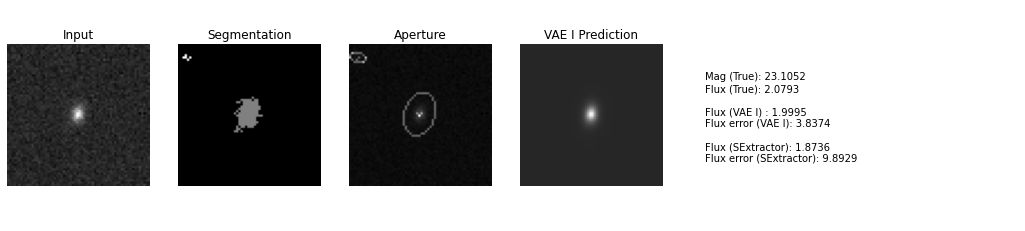

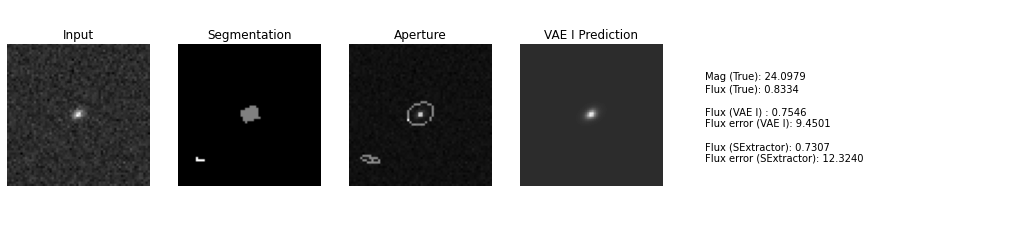

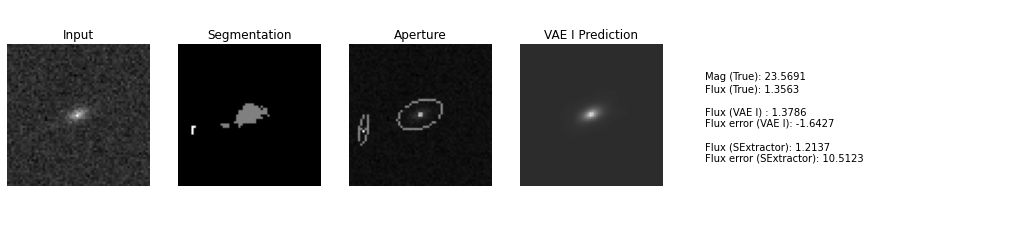

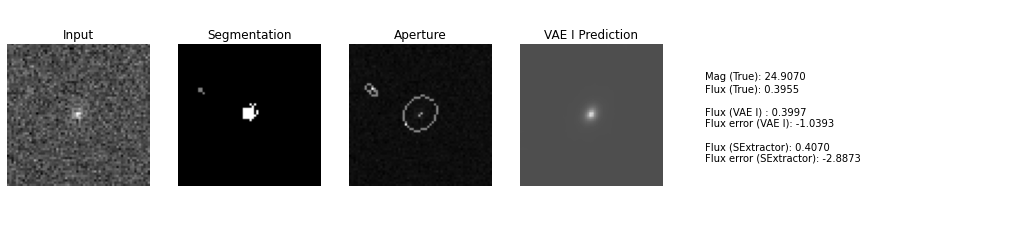

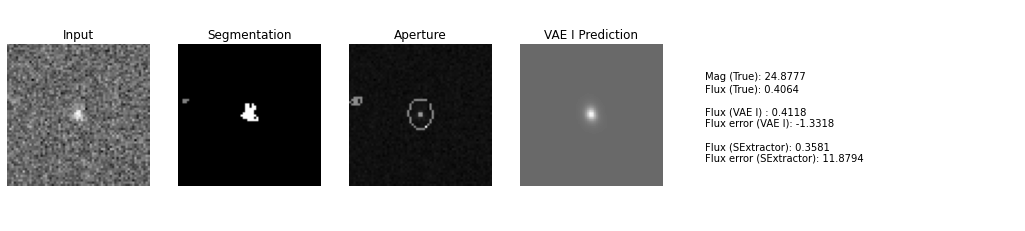

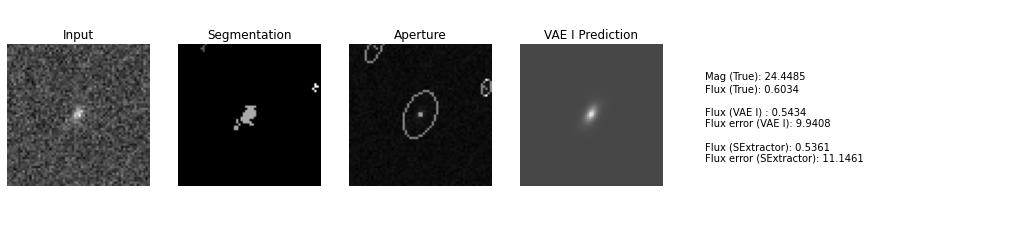

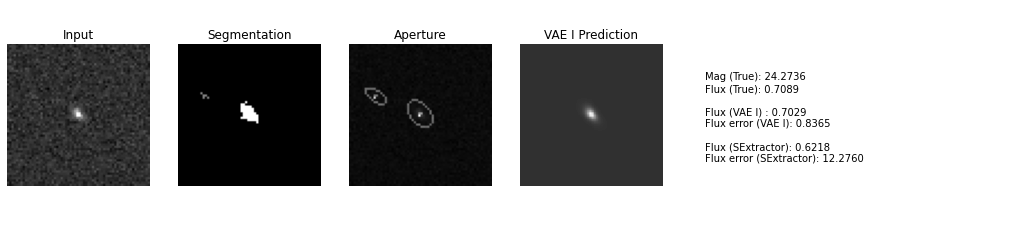

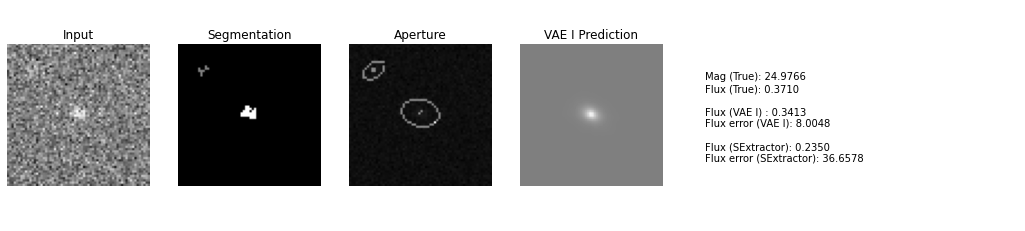

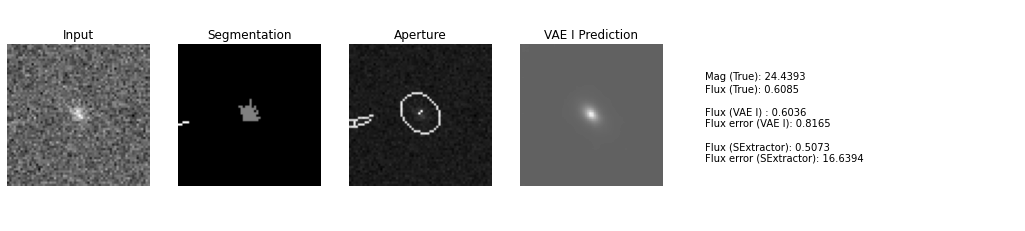

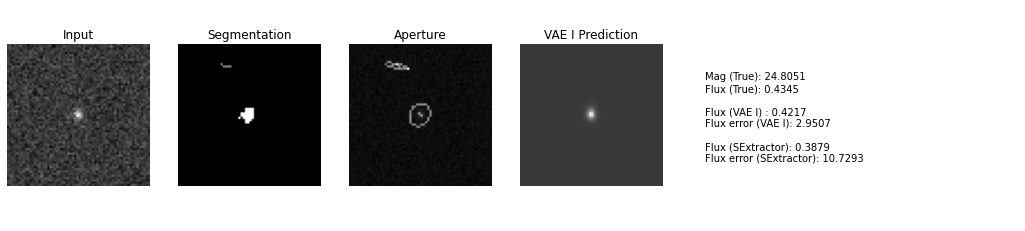

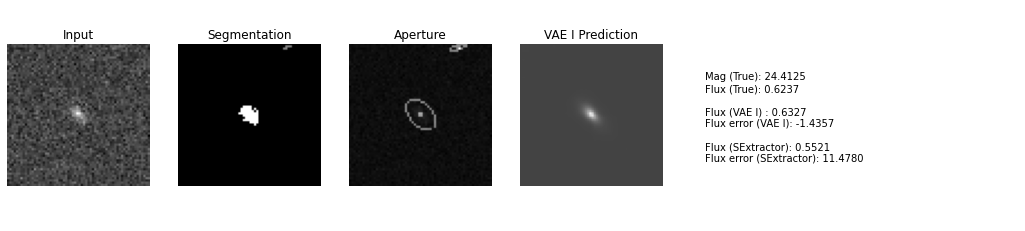

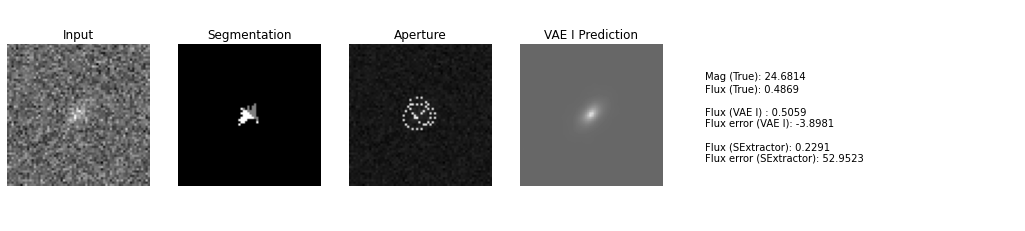

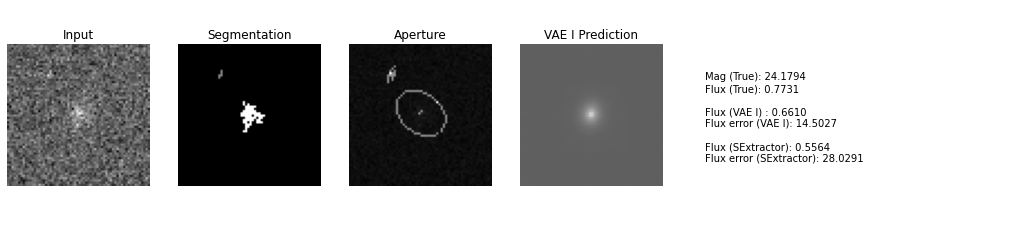

In [ ]:
for n in cat_sext_test[cat_sext_test['NO_OBJECTS'] > 1.0].index.tolist()[:20]: 

  ### SExtractor 

  fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(14.8, 4))

  im1 = ax0.imshow(sext_X_test_img[n], cmap='gray')
  ax0.set_title('Input')
  ax0.axis('off')

  im2 = ax1.imshow(sext_X_test_seg[n], cmap='gray')
  ax1.set_title('Segmentation')
  ax1.axis('off')

  im3 = ax2.imshow(sext_X_test_apr[n], cmap='gray')
  ax2.set_title('Aperture')
  ax2.axis('off')

  im4 = ax3.imshow(Y_test_predict[n], cmap='gray')
  ax3.set_title('VAE I Prediction')
  ax3.axis('off')

  images = [im1, im4]
  vmin = np.min([image.get_array().min() for image in images])
  vmax = np.max([image.get_array().max() for image in images])
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
      im.set_norm(norm)

  catalog_mag = cat_test.iloc[n, 4]
  catalog_flux = MagToFlux(zp, catalog_mag)

  vae_flux = np.sum(Y_test_predict[n])
  vae_mag = FluxToMag(zp, vae_flux)

  vae_error_flux = (catalog_flux-vae_flux)*100/catalog_flux
  vae_error_mag = (catalog_mag-vae_mag)*100

  sext_flux = cat_sext_test.loc[n, 'SEXT_BKG_CORRECT_FLUX']
  sext_error_flux = (catalog_flux-sext_flux)*100/catalog_flux

  if sext_flux == 0: 
    sext_mag = None
    sext_error_mag = None 
  else: 
    sext_mag = FluxToMag(zp, sext_flux)
    sext_error_mag = (catalog_mag-sext_mag)*100

  

  # info = f"Catalog Mag: {catalog_mag}\nCatalog Flux: {format(catalog_flux, '.4f')}\n\nVAE Flux: {format(vae_flux, '.4f')}\nVAE Flux Error: {format(vae_error_flux, '.4f')}\n\nSExtractor Flux: {format(sext_flux, '.4f')}\nSExtractor Flux Error:{format(sext_error_flux, '.4f')}"
  info = f"Mag (True): {format(catalog_mag, '.4f')}\nFlux (True): {format(catalog_flux, '.4f')}\n\nFlux (VAE I) : {format(vae_flux, '.4f')}\nFlux error (VAE I): {format(vae_error_flux, '.4f')}\n\nFlux (SExtractor): {format(sext_flux, '.4f')}\nFlux error (SExtractor): {format(sext_error_flux, '.4f')}"

  left, width = 0, 3.5
  bottom, height = 0.18, 0.66
  right = left + width
  top = bottom + height
  p = plt.Rectangle((left, bottom), width, height, fill=False, linewidth=0)
  p.set_transform(ax3.transAxes)
  p.set_clip_on(False)
  ax4.add_patch(p)
  ax4.axis('off')

  ax4.text(left+0.1, top-0.35, info,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax4.transAxes)

  ax4.axis('off')

  plt.show()

##### Where SExtractor error is very high

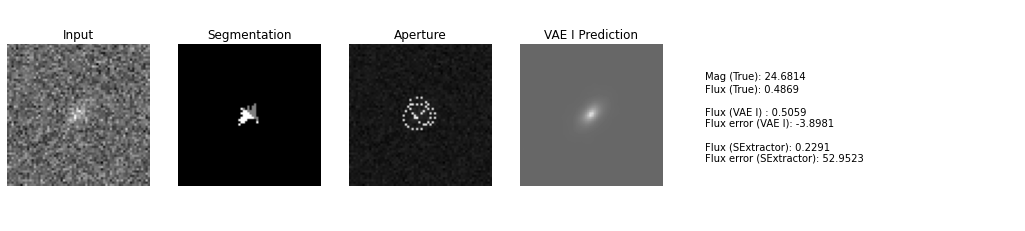

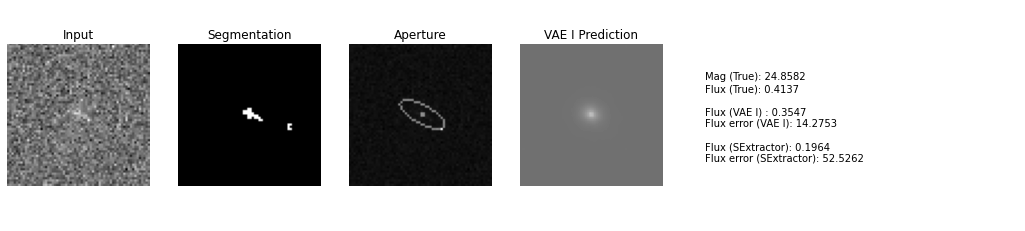

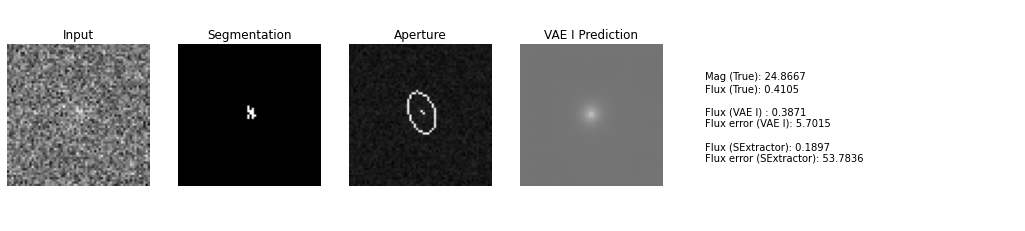

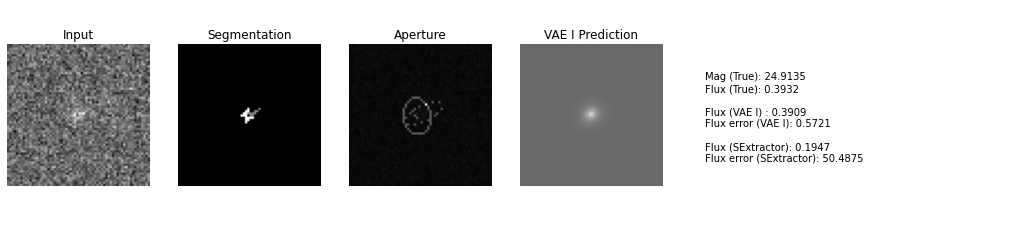

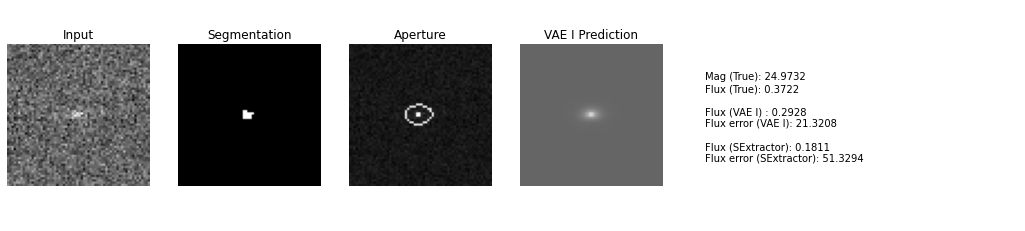

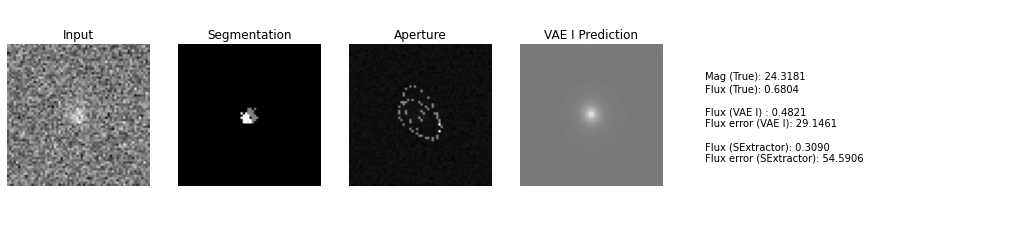

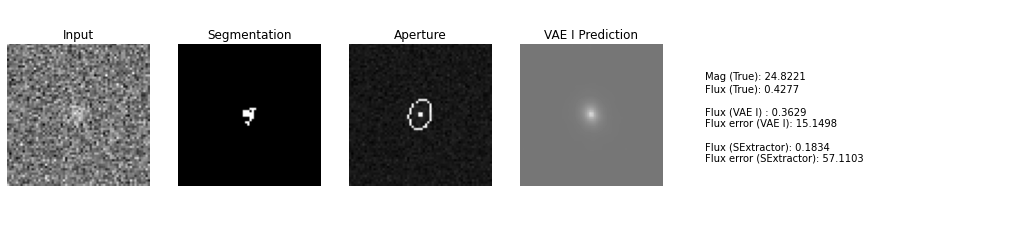

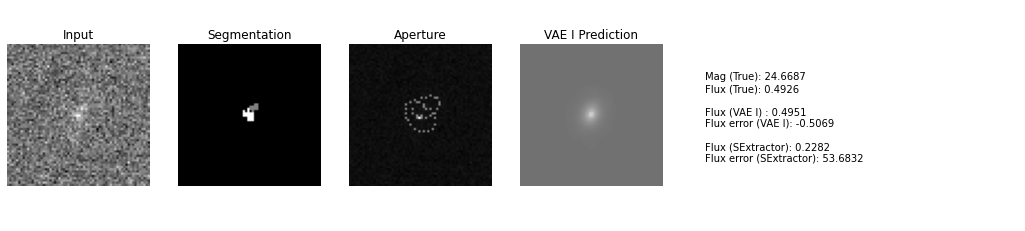

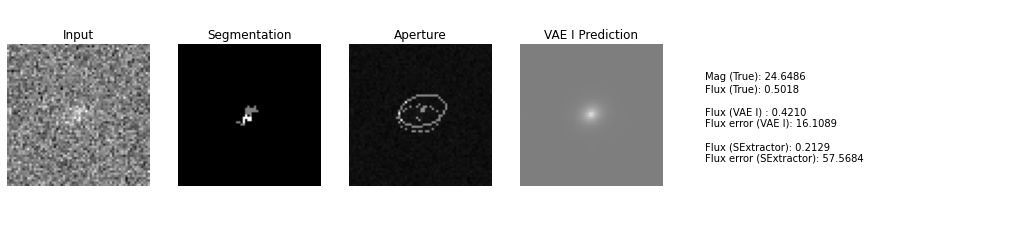

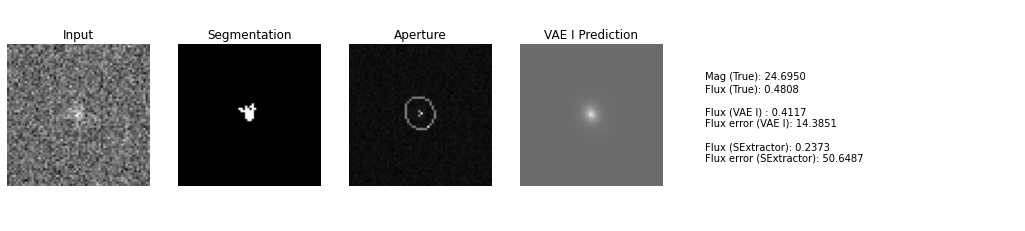

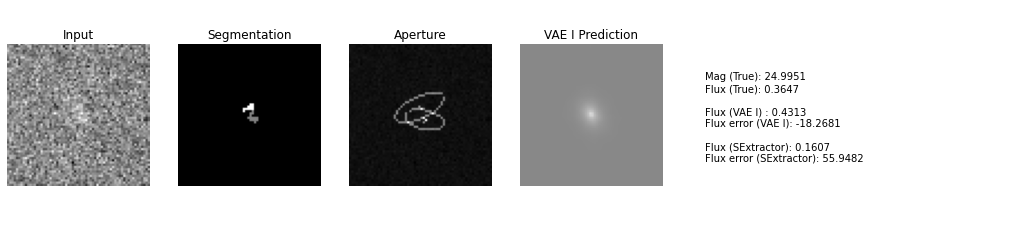

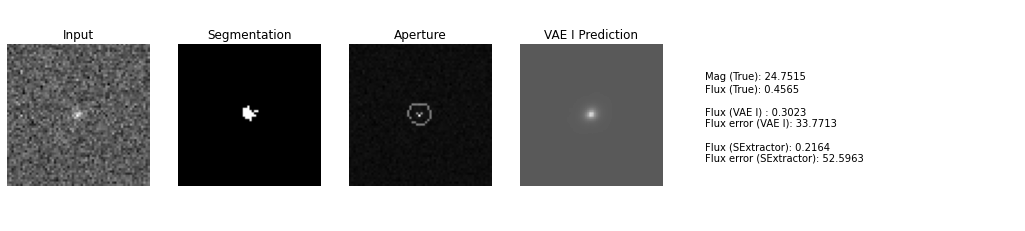

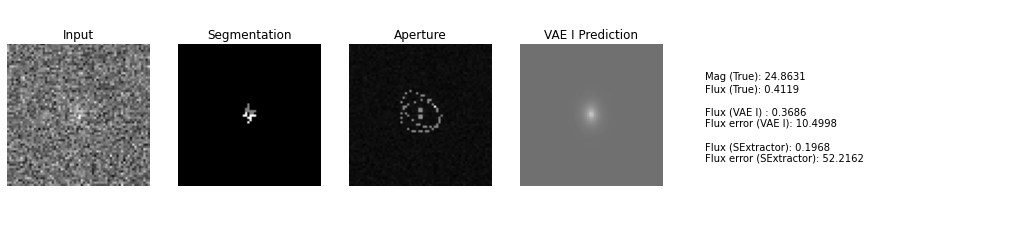

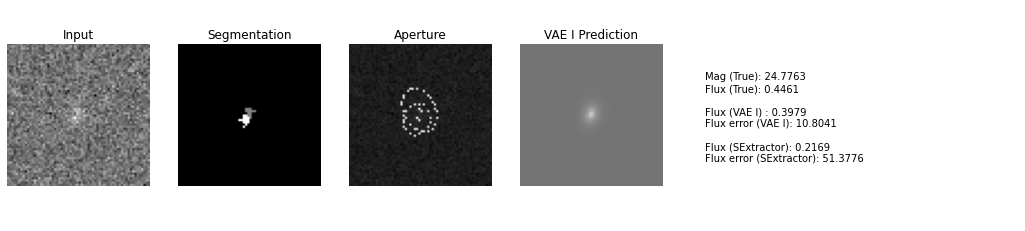

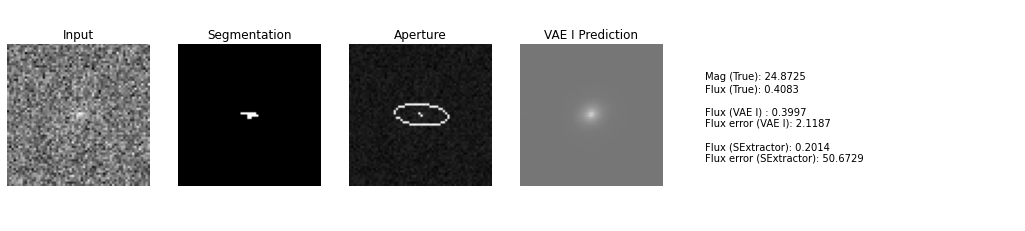

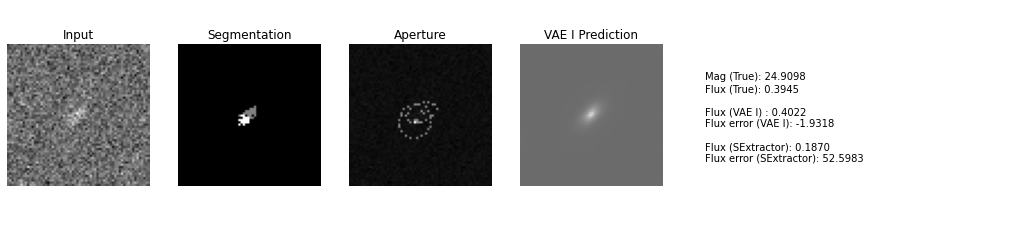

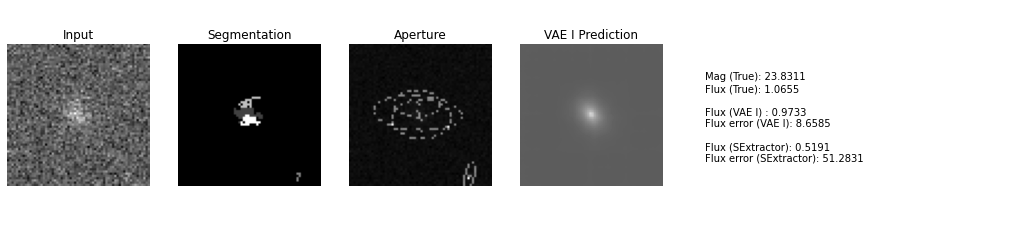

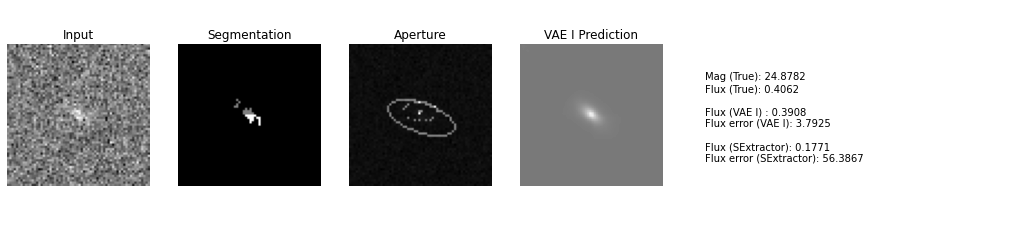

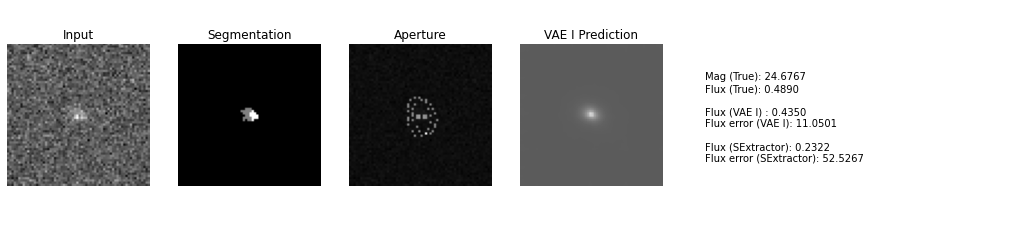

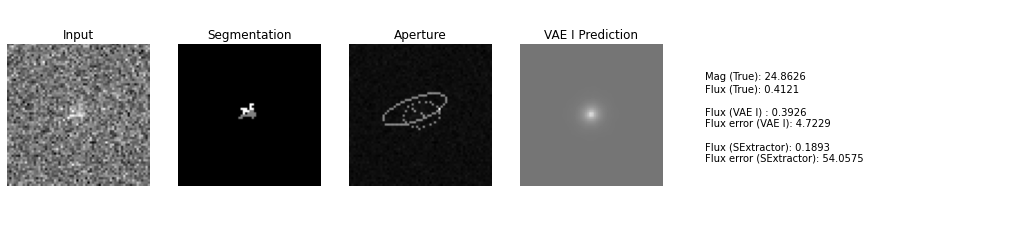

In [ ]:
for n in cat_sext_test[cat_sext_test['ERROR_SEXT'].between(-0.6, -0.5)].index.tolist()[:20]: 

  ### SExtractor 

  fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(14.8, 4))

  im1 = ax0.imshow(sext_X_test_img[n], cmap='gray')
  ax0.set_title('Input')
  ax0.axis('off')

  im2 = ax1.imshow(sext_X_test_seg[n], cmap='gray')
  ax1.set_title('Segmentation')
  ax1.axis('off')

  im3 = ax2.imshow(sext_X_test_apr[n], cmap='gray')
  ax2.set_title('Aperture')
  ax2.axis('off')

  im4 = ax3.imshow(Y_test_predict[n], cmap='gray')
  ax3.set_title('VAE I Prediction')
  ax3.axis('off')

  images = [im1, im4]
  vmin = np.min([image.get_array().min() for image in images])
  vmax = np.max([image.get_array().max() for image in images])
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
      im.set_norm(norm)

  catalog_mag = cat_test.iloc[n, 4]
  catalog_flux = MagToFlux(zp, catalog_mag)

  vae_flux = np.sum(Y_test_predict[n])
  vae_mag = FluxToMag(zp, vae_flux)

  vae_error_flux = (catalog_flux-vae_flux)*100/catalog_flux
  vae_error_mag = (catalog_mag-vae_mag)*100

  sext_flux = cat_sext_test.loc[n, 'SEXT_BKG_CORRECT_FLUX']
  sext_error_flux = (catalog_flux-sext_flux)*100/catalog_flux

  if sext_flux == 0: 
    sext_mag = None
    sext_error_mag = None 
  else: 
    sext_mag = FluxToMag(zp, sext_flux)
    sext_error_mag = (catalog_mag-sext_mag)*100

  

  info = f"Mag (True): {format(catalog_mag, '.4f')}\nFlux (True): {format(catalog_flux, '.4f')}\n\nFlux (VAE I) : {format(vae_flux, '.4f')}\nFlux error (VAE I): {format(vae_error_flux, '.4f')}\n\nFlux (SExtractor): {format(sext_flux, '.4f')}\nFlux error (SExtractor): {format(sext_error_flux, '.4f')}"

  left, width = 0, 3.5
  bottom, height = 0.18, 0.66
  right = left + width
  top = bottom + height
  p = plt.Rectangle((left, bottom), width, height, fill=False, linewidth=0)
  p.set_transform(ax3.transAxes)
  p.set_clip_on(False)
  ax4.add_patch(p)
  ax4.axis('off')

  ax4.text(left+0.1, top-0.35, info,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax4.transAxes)

  ax4.axis('off')

  plt.show()